In [1]:
from fractions import Fraction
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import numpy as np
import os
import pandas as pd
import re

In [2]:
datasets = ['face']
colors = ['red', 'orange', 'green', 'blue', 'purple', 'gray']

build_path = os.path.join(os.path.dirname(os.path.dirname(os.path.abspath('__file__'))), 'build')

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rcParams['font.size'] = 12

In [3]:
def num_formatter(x, pos):
    intx = int(x)

    if intx == 0:
        return '0'
    if intx >= 1e9:
        return f'{intx / 1e9:.0f}B'
    if intx >= 1e6:
        return f'{intx / 1e6:.0f}M'
    if intx >= 1e3:
        return f'{intx / 1e3:.0f}K'
    if _:
        return str(x)

formatter = FuncFormatter(num_formatter)

def camelcase(str):
    return str[:1].upper() + str[1:]

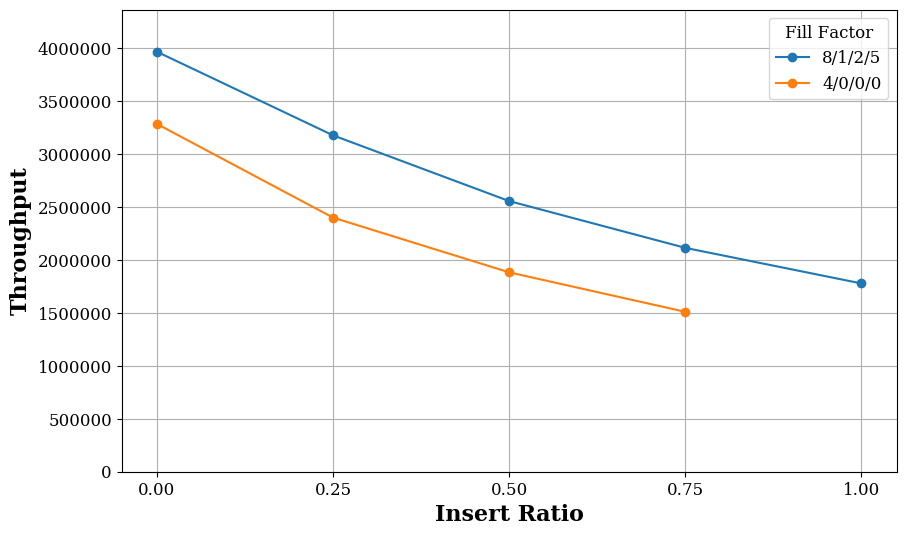

In [6]:

build_path = os.path.join(os.path.dirname(os.path.dirname(os.path.abspath('__file__'))), 'build')
file_name = os.path.join(build_path, 'out.csv')

labels = ['8/1/2/5', '4/0/0/0']

df = pd.read_csv(file_name, keep_default_na=False, na_filter=False)

empty_rows = df.index[df.isnull().all(axis=1)]

group_size = 5
group_start_idx = 0
groups = []

while group_start_idx < len(df):
    group = df.iloc[group_start_idx:(group_start_idx + group_size)]
    if not group.empty:
        groups.append(group)
    group_start_idx += group_size

last_group = df.iloc[group_start_idx:]
if not last_group.empty:
    groups.append(last_group)

ymax = 0
plt.figure(figsize=(10, 6))
for i, group in enumerate(groups):
    throughputs = group['throughput']
    ymax = max(ymax, throughputs.max())
    throughputs = throughputs.to_numpy()
    insert_ratios = group['insert_ratio'].to_numpy()
    plt.plot(insert_ratios, throughputs, marker='o', label=labels[i])

plt.xlabel('Insert Ratio', fontsize=16, fontweight='bold')
plt.ylabel('Throughput', fontsize=16, fontweight='bold')
plt.xticks(df['insert_ratio'].unique())
# plt.gca().yaxis.set_major_formatter(formatter)
plt.ylim(0, ymax * 1.1)
plt.legend(title='Fill Factor')
plt.grid(True)
plt.show()

<Figure size 640x480 with 0 Axes>

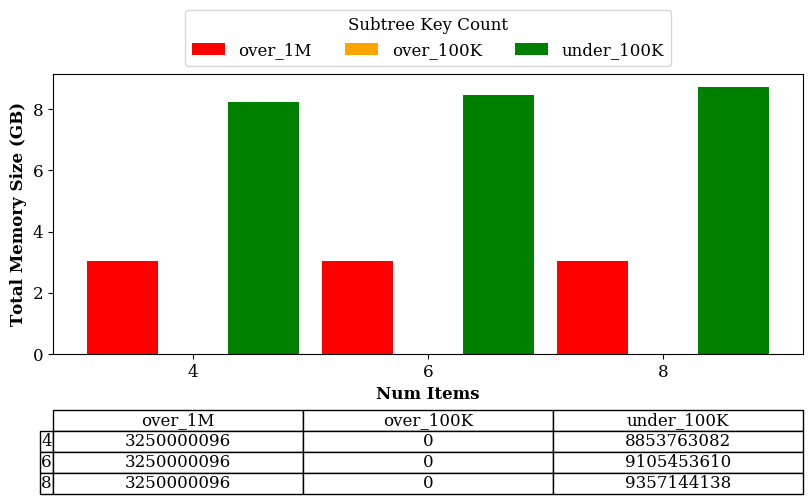

In [4]:
all_files = os.listdir(build_path)
csv_files = [f for f in all_files if f.endswith('.csv')]
csv_file_paths = {}    

for dataset in datasets:
    plt.figure()

    data_agg = {'over_1M': {}, 'over_100K': {}, 'under_100K': {}}
        
    for file_name in csv_files:
        match = re.match(rf'{dataset}_(\d+)_5\.csv', file_name)
        if not match:
            continue

        num_items = int(match.group(1))
        file_path = os.path.join(build_path, file_name)
        df = pd.read_csv(file_path)
        
        if num_items not in data_agg['over_1M']:
            for category in data_agg.keys():
                data_agg[category][num_items] = 0
                
        for size_value, mem in zip(df['size'], df['mem']):
            category = ''
            if size_value >= 1000000:
                category = 'over_1M'
            elif size_value >= 100000:
                category = 'over_100K'
            else:
                category = 'under_100K'
            
            data_agg[category][num_items] += mem

    num_items_sorted = sorted({key for category in data_agg for key in data_agg[category].keys()})

    bar_width = 0.3
    index = np.arange(len(num_items_sorted))

    fig, ax = plt.subplots(figsize=(10, 8))

    for i, (category, color) in enumerate(zip(data_agg.keys(), colors)):
        sizes_gb = [data_agg[category][num] / (1024**3) for num in num_items_sorted]
        ax.bar(index + i * bar_width, sizes_gb, bar_width, label=category, color=color)

    cell_text = []
    for num in num_items_sorted:
        row = [data_agg[category][num] for category in data_agg.keys()]
        cell_text.append(row)
        
    table = ax.table(cellText=cell_text, rowLabels=num_items_sorted, colLabels=list(data_agg.keys()),
        loc='bottom', bbox=[0, -0.5, 1, 0.3], rowLoc='center', colLoc='center', cellLoc='center')

    plt.subplots_adjust(left=0.2, bottom=0.2, right=0.95, top=0.55)

    ax.set_xlabel('Num Items', fontweight='bold')
    ax.set_ylabel('Total Memory Size (GB)', fontweight='bold')
    ax.set_xticks(index + bar_width)
    ax.set_xticklabels(num_items_sorted)
    ax.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, 1), title='Subtree Key Count')

    plt.show()
    
# for dataset in datasets:
#     plt.figure()
    
#     i = 0
#     count = 0
#     over_100000 = 0
#     over_1000000 = 0
#     data_agg = {}

#     for file_name in csv_files:
#         match = re.match(rf'{dataset}_(\d+)_5\.csv', file_name)
#         if not match:
#             continue

#         num_items = int(match.group(1))
#         file_path = os.path.join(build_path, file_name)
#         df = pd.read_csv(file_path)
            
#         for size_value in df['size']:
#             if size_value >= 1000000:
#                 over_1000000 += 1
#             elif size_value >= 100000:
#                 over_100000 += 1
#             else:
#                 count += 1
        
#         for depth in sorted(df['depth'].unique()):
#             depth_df = df[df['depth'] == depth]
#             total_size_bytes = depth_df['mem'].sum()
#             total_size_gb = total_size_bytes / (1024**3)
            
#             if depth not in data_agg:
#                 data_agg[depth] = []
#             data_agg[depth].append((num_items, total_size_gb))
    
#         print('over 1000000:', over_1000000)
#         print('over 100000:', over_100000)
#         print('under 100000:', count)

#     for depth in sorted(data_agg.keys()):
#         data_agg[depth].sort(key=lambda x: x[0])

#     bottoms = np.zeros(len(data_agg[next(iter(sorted(data_agg.keys())))]))
#     xticks = sorted({x[0] for depth in data_agg for x in data_agg[depth]})
#     xtick_labels = [str(Fraction(2 / x).limit_denominator()) for x in xticks]
    
#     ax1 = plt.gca()
#     ax2 = ax1.twinx()
    
#     for depth in sorted(data_agg.keys()):
#         num_items = [x[0] for x in data_agg[depth]]
#         total_sizes_gb = [x[1] for x in data_agg[depth]]
#         ax1.bar(num_items, total_sizes_gb, bottom=bottoms, label=depth, color=colors[i % len(colors)])
#         bottoms += total_sizes_gb
#         i += 1

#     proportion_1_6_gb = [sum(data_agg[depth][j][1] for depth in data_agg) / 1.6 for j in range(len(xticks))]
#     ax2.plot(xticks, proportion_1_6_gb, 'x--', color='black')

#     ax1.set_xlabel('Initialized Node Utilization', fontweight='bold')
#     ax1.set_ylabel('Memory Size (GB)', fontweight='bold')
#     ax1.set_xticks(xticks)
#     ax1.set_xticklabels(xtick_labels)
#     ax1.set_ylim(0, max(bottoms) * 1.1)
#     ax1.legend(loc='lower right', title='Depth')
    
#     ax2.set_ylabel('SAF', fontweight='bold')
#     ax2.set_ylim(0, max(proportion_1_6_gb) * 1.1)
    
#     plt.show()

[2, 3, 4, 5]


<Figure size 640x480 with 0 Axes>

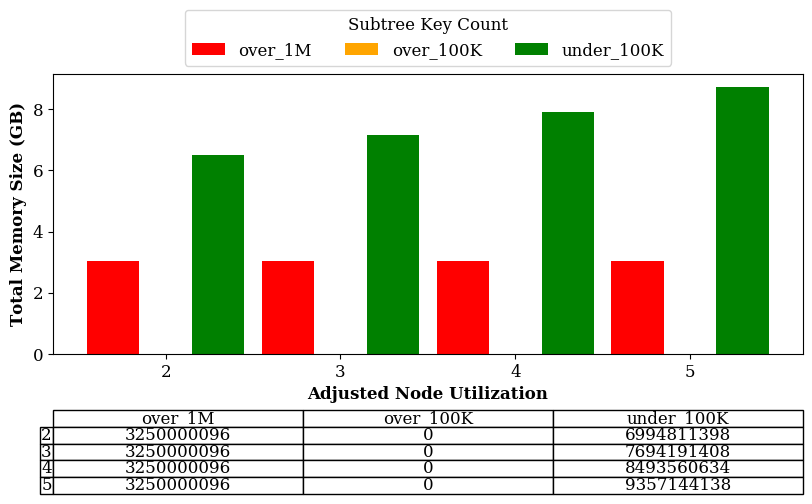

In [5]:
all_files = os.listdir(build_path)
csv_files = [f for f in all_files if f.endswith('.csv')]
csv_file_paths = {}

for dataset in datasets:
    plt.figure()

    data_agg = {'over_1M': {}, 'over_100K': {}, 'under_100K': {}}

    for file_name in csv_files:
        match = re.match(rf'{dataset}_8_(\d+)\.csv', file_name)
        if not match:
            continue

        gap_count = int(match.group(1))
        file_path = os.path.join(build_path, file_name)
        df = pd.read_csv(file_path)
        
        if gap_count not in data_agg['over_1M']:
            for category in data_agg.keys():
                data_agg[category][gap_count] = 0
                
        for size_value, mem in zip(df['size'], df['mem']):
            category = ''
            if size_value >= 1000000:
                category = 'over_1M'
            elif size_value >= 100000:
                category = 'over_100K'
            else:
                category = 'under_100K'
            
            data_agg[category][gap_count] += mem

    gap_count_sorted = sorted({key for category in data_agg for key in data_agg[category].keys()})

    bar_width = 0.3
    index = np.arange(len(gap_count_sorted))

    fig, ax = plt.subplots(figsize=(10, 8))

    for i, (category, color) in enumerate(zip(data_agg.keys(), colors)):
        sizes_gb = [data_agg[category][num] / (1024**3) for num in gap_count_sorted]
        ax.bar(index + i * bar_width, sizes_gb, bar_width, label=category, color=color)

    cell_text = []
    for num in gap_count_sorted:
        row = [data_agg[category][num] for category in data_agg.keys()]
        cell_text.append(row)
        
    table = ax.table(cellText=cell_text, rowLabels=gap_count_sorted, colLabels=list(data_agg.keys()),
        loc='bottom', bbox=[0, -0.5, 1, 0.3], rowLoc='center', colLoc='center', cellLoc='center')

    plt.subplots_adjust(left=0.2, bottom=0.2, right=0.95, top=0.55)

    ax.set_xlabel('Adjusted Node Utilization', fontweight='bold')
    ax.set_ylabel('Total Memory Size (GB)', fontweight='bold')
    ax.set_xticks(index + bar_width)
    ax.set_xticklabels(gap_count_sorted)
    ax.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, 1), title='Subtree Key Count')

    plt.show()

# for dataset in datasets:
#     plt.figure()

#     i = 0
#     data_agg = {}

#     for file_name in csv_files:
#         match = re.match(rf'{dataset}_8_(\d+)\.csv', file_name)
#         if not match:
#             continue

#         gap_count = int(match.group(1))
#         file_path = os.path.join(build_path, file_name)
#         df = pd.read_csv(file_path)
        
#         for depth in sorted(df['depth'].unique()):
#             depth_df = df[df['depth'] == depth]
#             total_size_bytes = depth_df['mem'].sum()
#             total_size_gb = total_size_bytes / (1024**3)
            
#             if depth not in data_agg:
#                 data_agg[depth] = []
#             data_agg[depth].append((gap_count, total_size_gb))

#     for depth in sorted(data_agg.keys()):
#         data_agg[depth].sort(key=lambda x: x[0])

#     bottoms = np.zeros(len(data_agg[next(iter(sorted(data_agg.keys())))]))
#     xticks = sorted({x[0] for depth in data_agg for x in data_agg[depth]})
#     xtick_labels = [str(Fraction(1 / (x + 1)).limit_denominator()) for x in xticks]
    
#     ax1 = plt.gca()
#     ax2 = ax1.twinx()
    
#     for depth in sorted(data_agg.keys()):
#         gap_counts = [x[0] for x in data_agg[depth]]
#         total_sizes_gb = [x[1] for x in data_agg[depth]]
#         ax1.bar(gap_counts, total_sizes_gb, bottom=bottoms, width=0.5, label=depth, color=colors[i])
#         bottoms += total_sizes_gb
#         i += 1

#     proportion_1_6_gb = [sum(data_agg[depth][j][1] for depth in data_agg) / 1.6 for j in range(len(xticks))]
#     ax2.plot(xticks, proportion_1_6_gb, 'x--', color='black')

#     ax1.set_xlabel('Adjusted Node Utilization', fontweight='bold')
#     ax1.set_ylabel('Memory Size (GB)', fontweight='bold')
#     ax1.set_ylim(0, max(bottoms) * 1.1)
#     ax1.set_xticks(xticks)
#     ax1.set_xticklabels(xtick_labels)
#     ax1.legend(loc='lower right', title='Depth')

#     ax2.set_ylabel('SAF', fontweight='bold')
#     ax2.set_ylim(0, max(proportion_1_6_gb) * 1.1)

#     plt.show()

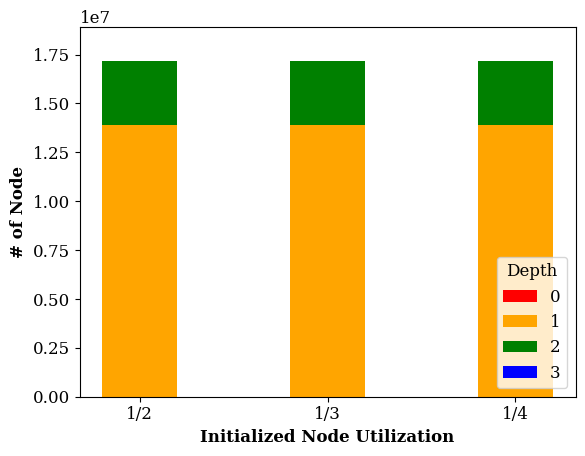

In [15]:
all_files = os.listdir(build_path)
csv_files = [f for f in all_files if f.endswith('.csv')]
csv_file_paths = {}

for dataset in datasets:
    plt.figure()

    i = 0
    data_agg = {}

    for file_name in csv_files:
        match = re.match(rf'{dataset}_(\d+)_5\.csv', file_name)
        if not match:
            continue

        num_items = int(match.group(1))
        file_path = os.path.join(build_path, file_name)
        df = pd.read_csv(file_path)
        
        for depth in sorted(df['depth'].unique()):
            depth_df = df[df['depth'] == depth]
            count = len(depth_df)
            
            if depth not in data_agg:
                data_agg[depth] = []
            data_agg[depth].append((num_items, count))

    for depth in sorted(data_agg.keys()):
        data_agg[depth].sort(key=lambda x: x[0])

    bottoms = np.zeros(len(data_agg[next(iter(sorted(data_agg.keys())))]))
    xticks = sorted({x[0] for depth in data_agg for x in data_agg[depth]})
    xtick_labels = [str(Fraction(2 / x).limit_denominator()) for x in xticks]
    
    for depth in sorted(data_agg.keys()):
        num_items = [x[0] for x in data_agg[depth]]
        count = [x[1] for x in data_agg[depth]]
        plt.bar(num_items, count, bottom=bottoms, label=depth, color=colors[i])
        bottoms += count
        i += 1

    ymax = plt.ylim()[1]

    plt.xlabel('Initialized Node Utilization', fontweight='bold')
    plt.ylabel('# of Node', fontweight='bold')
    plt.ylim(0, ymax * 1.1)
    plt.xticks(xticks, labels=xtick_labels)
    plt.legend(loc='lower right', title='Depth')
    plt.show()

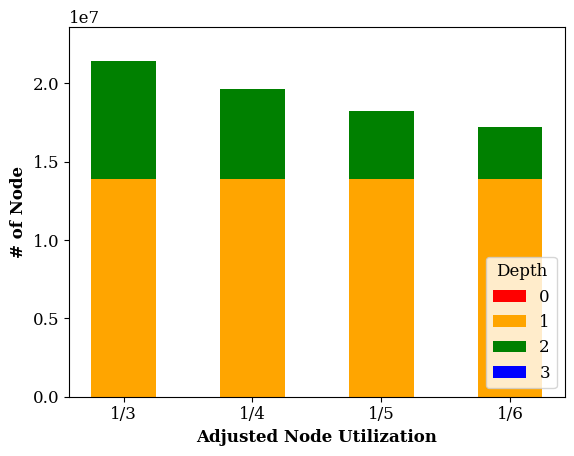

In [16]:
all_files = os.listdir(build_path)
csv_files = [f for f in all_files if f.endswith('.csv')]
csv_file_paths = {}

for dataset in datasets:
    plt.figure()

    i = 0
    data_agg = {}

    for file_name in csv_files:
        match = re.match(rf'{dataset}_8_(\d+)\.csv', file_name)
        if not match:
            continue

        gap_count = int(match.group(1))
        file_path = os.path.join(build_path, file_name)
        df = pd.read_csv(file_path)
        
        for depth in sorted(df['depth'].unique()):
            depth_df = df[df['depth'] == depth]
            count = len(depth_df)
            
            if depth not in data_agg:
                data_agg[depth] = []
            data_agg[depth].append((gap_count, count))

    for depth in sorted(data_agg.keys()):
        data_agg[depth].sort(key=lambda x: x[0])

    bottoms = np.zeros(len(data_agg[next(iter(sorted(data_agg.keys())))]))
    xticks = sorted({x[0] for depth in data_agg for x in data_agg[depth]})
    xtick_labels = [str(Fraction(1 / (x + 1)).limit_denominator()) for x in xticks]
    
    for depth in sorted(data_agg.keys()):
        gap_count = [x[0] for x in data_agg[depth]]
        count = [x[1] for x in data_agg[depth]]
        plt.bar(gap_count, count, bottom=bottoms, width=0.5, label=depth, color=colors[i])
        bottoms += count
        i += 1

    ymax = plt.ylim()[1]

    plt.xlabel('Adjusted Node Utilization', fontweight='bold')
    plt.ylabel('# of Node', fontweight='bold')
    plt.ylim(0, ymax * 1.1)
    plt.xticks(xticks, labels=xtick_labels)
    plt.legend(loc='lower right', title='Depth')
    plt.show()

In [ ]:
for dataset in datasets:
    df_combined = pd.DataFrame()
    xticks = set()

    for file_name in csv_files:
        match = re.match(rf'{dataset}_(\d+)_5\.csv', file_name)
        if not match:
            continue

        num_items = int(match.group(1))
        file_path = os.path.join(build_path, file_name)
        df = pd.read_csv(file_path)
        xticks.add(num_items)
        depth_counts = df['depth'].value_counts(normalize=True).sort_index().rename_axis('depth').reset_index(name=f'proportion_{i}')
        depth_counts[f'proportion_{i}'] *= 100 
        df_combined = pd.merge(df_combined, depth_counts, on='depth', how='outer') if not df_combined.empty else depth_counts
        
    df_combined.fillna(0, inplace=True)
    bottom_proportion = np.zeros(len(xticks))  

    plt.figure()
    bar_width = 0.50
    xticks = list(xticks)

    for i in df_combined['depth']:
        proportions = df_combined[[f'proportion_{j}' for j in range(len(datasets))]].loc[df_combined['depth'] == i].values.flatten()
        plt.bar(xticks, proportions, width=bar_width, bottom=bottom_proportion, label=f'Depth {i}', color=colors[i])
        bottom_proportion += proportions

    ymax = plt.ylim()[1]
    plt.ylim(0, ymax * 1.1)

    plt.ylabel('Proportion of Node Count (%)', fontweight='bold')
    plt.title('Proportion of Node Count by Workload (Relative Value)', fontweight='bold')
    plt.xticks(indices, datasets, fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Node Depth')
    plt.tight_layout(rect=[0, 0, 0.85, 1])  
    plt.show()

Loading face_8_2.csv with 2 gap
Loading face_8_4.csv with 4 gap
Loading face_8_5.csv with 5 gap
Loading face_8_3.csv with 3 gap


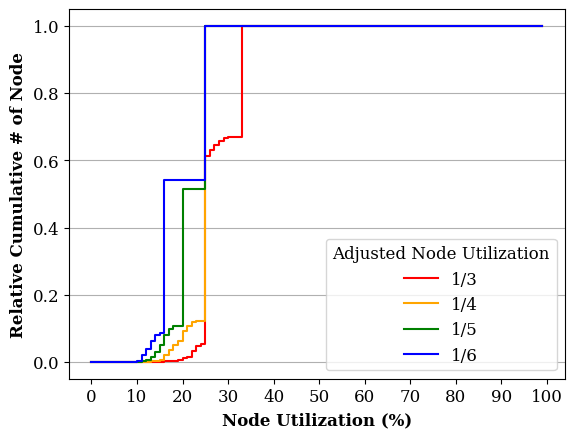

In [22]:
all_files = os.listdir(build_path)
csv_files = [f for f in all_files if f.endswith('.csv')]

for dataset in datasets:  
  i = 0
  data_to_plot = []

  for file_name in csv_files:
    match = re.match(rf'{dataset}_8_(\d+)\.csv', file_name)
    if not match:
      continue

    gap_count = int(match.group(1))
    print(f'Loading {file_name} with {gap_count} gap')
    file_path = os.path.join(build_path, file_name)
    df = pd.read_csv(file_path, header=None, low_memory=False)
    total_count = len(df)
    total_values = df.iloc[2:, 0].astype(float)
    null_values = df.iloc[2:, 1].astype(float)
    non_null_percentages = ((total_values - null_values) / total_values) * 100
    percent_intervals = np.arange(0, 101, 1)
    counts, _ = np.histogram(non_null_percentages, bins=percent_intervals)
    counts = np.asarray(counts) / total_count
    cumulative_counts = np.cumsum(counts)
    label = f'{Fraction(1 / (gap_count + 1)).limit_denominator(1000)}'

    data_to_plot.append((gap_count, percent_intervals[:-1], cumulative_counts, label))

  data_to_plot.sort(key=lambda x: x[0])

  plt.figure()

  for _, percent_intervals, cumulative_counts, label in data_to_plot:
    plt.plot(percent_intervals, cumulative_counts, drawstyle='steps-post', label=label, color=colors[i])
    i += 1

  plt.xlabel('Node Utilization (%)', fontweight='bold')
  plt.ylabel('Relative Cumulative # of Node', fontweight='bold')
  plt.xticks(np.arange(0, 101, 10))
  plt.yticks()
  plt.grid(axis='y')
  plt.legend(title='Adjusted Node Utilization', loc='lower right')
  plt.show()

Loading face_4_5.csv with 4 items
Loading face_8_5.csv with 8 items
Loading face_6_5.csv with 6 items


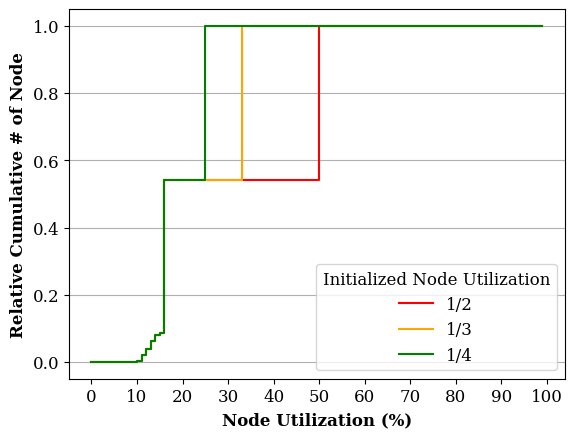

In [24]:
all_files = os.listdir(build_path)
csv_files = [f for f in all_files if f.endswith('.csv')]

for dataset in datasets:  
  i = 0
  data_to_plot = []
  
  for file_name in csv_files:
    match = re.match(rf'{dataset}_(\d+)_5\.csv', file_name)
    if not match:
      continue

    num_items = int(match.group(1))
    print(f'Loading {file_name} with {num_items} items')
    file_path = os.path.join(build_path, file_name)
    df = pd.read_csv(file_path, header=None, low_memory=False)
    total_count = len(df)
    total_values = df.iloc[2:, 0].astype(float)
    null_values = df.iloc[2:, 1].astype(float)
    non_null_percentages = ((total_values - null_values) / total_values) * 100
    percent_intervals = np.arange(0, 101, 1)
    counts, _ = np.histogram(non_null_percentages, bins=percent_intervals)
    counts = np.asarray(counts) / total_count
    cumulative_counts = np.cumsum(counts)
    label = f'{Fraction(2 / num_items).limit_denominator(1000)}'
    
    data_to_plot.append((num_items, percent_intervals[:-1], cumulative_counts, label))

  data_to_plot.sort(key=lambda x: x[0])
  
  plt.figure()
  
  for _, percent_intervals, cumulative_counts, label in data_to_plot:
    plt.plot(percent_intervals, cumulative_counts, drawstyle='steps-post', label=label, color=colors[i])
    i += 1
  
  plt.xlabel('Node Utilization (%)', fontweight='bold')
  plt.ylabel('Relative Cumulative # of Node', fontweight='bold')
  plt.xticks(np.arange(0, 101, 10))
  plt.yticks()
  plt.grid(axis='y')
  plt.legend(title='Initialized Node Utilization')
  plt.show()

In [ ]:
csv_file_names = [os.path.join(build_path, f'{dataset}.csv') for dataset in datasets]

df_combined = pd.DataFrame()

for i, file_name in enumerate(csv_file_names):
    df = pd.read_csv(file_name)
    depth_counts = df['depth'].value_counts(normalize=False).sort_index().rename_axis('depth').reset_index(name=f'count_{i}')
    df_combined = pd.merge(df_combined, depth_counts, on='depth', how='outer') if not df_combined.empty else depth_counts

df_combined.fillna(0, inplace=True)

bar_width = 0.3  
indices = np.arange(len(datasets))  

bottom_count = np.zeros(len(datasets))

for i in df_combined['depth']:
    counts = df_combined[[f'count_{j}' for j in range(len(datasets))]].loc[df_combined['depth'] == i].values.flatten()
    plt.bar(indices, counts, width=bar_width, bottom=bottom_count, label=f'{i}', color=colors[i])
    bottom_count += counts

ymax = plt.ylim()[1]
plt.ylim(0, ymax * 1.1)

plt.title('# of Node per Depth after Bulk Loading', fontweight='bold')
plt.xticks(indices, datasets)
plt.xlabel('Dataset', fontweight='bold')
plt.yticks(fontsize=12)
plt.ylabel('# of Node', fontweight='bold')
plt.gca().yaxis.set_major_formatter(formatter)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Depth')
plt.show()

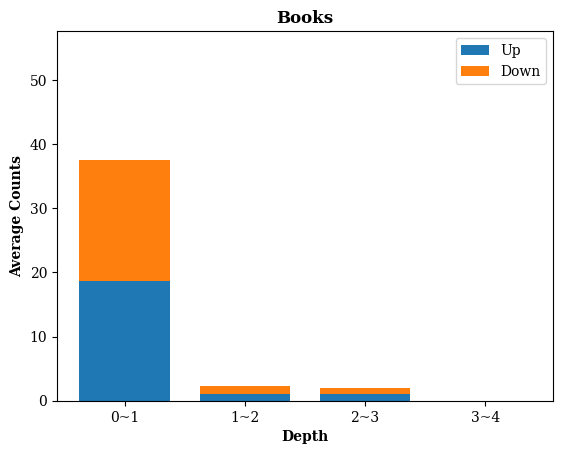

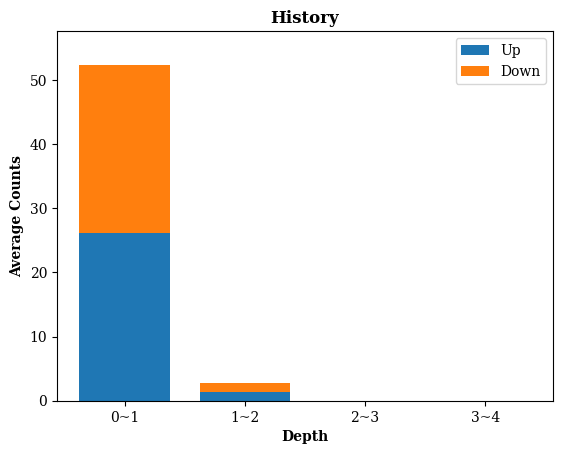

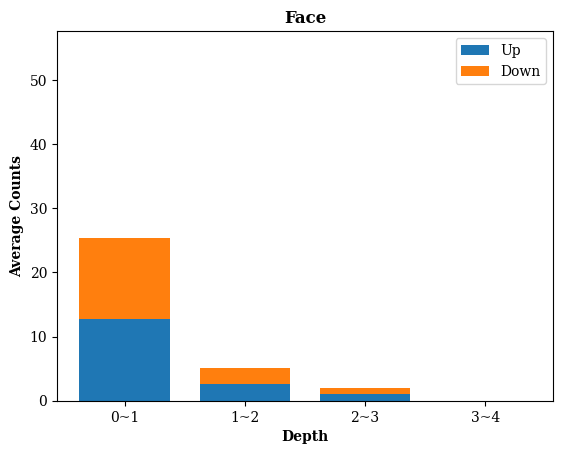

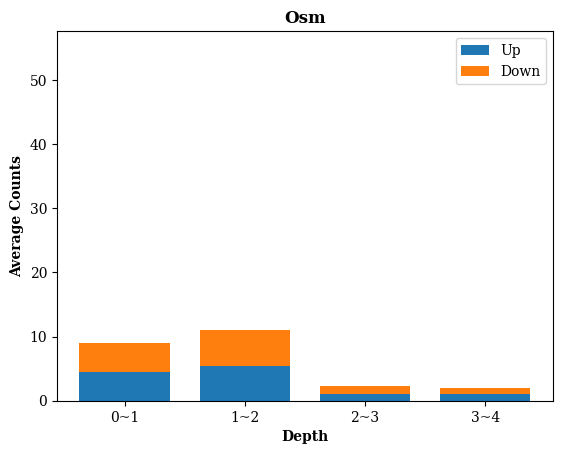

In [ ]:
csv_file_names = [os.path.join(build_path, f'{dataset}_count.csv') for dataset in datasets]

all_depths = set()

for file_name in csv_file_names:
    df = pd.read_csv(file_name)
    for depth, _, _ in df.itertuples(index=False):
        try:
            all_depths.add(int(depth))
        except ValueError:
            continue

all_depths = sorted(all_depths)

averages = np.arange(len(csv_file_names), dtype=object)
global_ups_downs = []

for i, file_name in enumerate(csv_file_names):
    depth_data = {}
    df = pd.read_csv(file_name)
    
    for depth, up, down in df.itertuples(index=False):
        try:
            depth = int(depth)
        except ValueError:
            continue
            
        if depth not in depth_data:
            depth_data[depth] = {'up': [], 'down': []}
        depth_data[depth]['up'].append(up)
        depth_data[depth]['down'].append(down)

    averages[i] = {depth: {'up': np.mean(info['up']), 'down': np.mean(info['down'])} for depth in all_depths for info in [depth_data.get(depth, {'up': [0], 'down': [0]})]}
    global_ups_downs.extend([averages[i][depth]['up'] + averages[i][depth]['down'] for depth in all_depths])

y_min = min(global_ups_downs)
y_max = max(global_ups_downs)

for i, file_name in enumerate(csv_file_names):
    ups = [averages[i][depth]['up'] for depth in all_depths]
    downs = [averages[i][depth]['down'] for depth in all_depths]

    fig, ax = plt.subplots()
    bar_width = 0.3
    index = np.arange(len(all_depths)) * (bar_width + 0.1)
    xlabels = [f'{int(depth)}~{int(depth) + 1}' for depth in all_depths]

    ax.bar(index, ups, bar_width, label='Up')
    ax.bar(index, downs, bar_width, bottom=ups, label='Down')

    ax.set_xlabel('Depth', fontweight='bold')
    ax.set_ylabel('Average Counts', fontweight='bold')
    ax.set_title(datasets[i][:1].upper() + datasets[i][1:], fontweight='bold')
    ax.set_xticks(index)
    ax.set_xticklabels(xlabels)
    ax.set_ylim([y_min, y_max * 1.1])
    ax.legend(loc='upper right')

    plt.show()

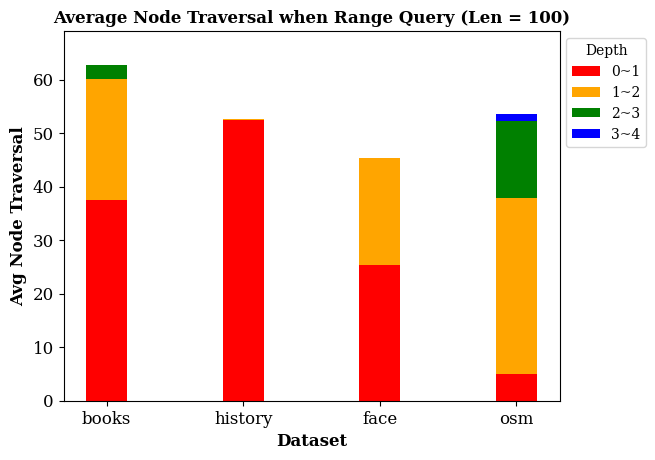

In [ ]:
csv_file_names = [os.path.join(build_path, f'{dataset}_count.csv') for dataset in datasets]

depth_totals = {}

def read_and_group_csv(file_name):
    df = pd.read_csv(file_name)
    grouped_data = []
    current_group = []
    for _, row in df.iterrows():
        if row['depth'] == '--------------------------':
            if current_group:
                grouped_data.append(pd.DataFrame(current_group, columns=['depth', 'up', 'down']))
                current_group = []
        else:
            current_group.append(row)
    if current_group:
        grouped_data.append(pd.DataFrame(current_group, columns=['depth', 'up', 'down']))
    return grouped_data

for dataset, file_name in zip(datasets, csv_file_names):
    grouped_data = read_and_group_csv(file_name)
    group_count = len(grouped_data)
    depth_totals[dataset] = {}
    
    for group in grouped_data:
        for _, row in group.iterrows():
            try:
                depth = int(row['depth'])
            except ValueError:
                continue
            
            total = row['up'] + row['down']
            
            if depth in depth_totals[dataset]:
                depth_totals[dataset][depth] += total
            else:
                depth_totals[dataset][depth] = total

dataset_avgs = {dataset: {depth: np.mean(totals) for depth, totals in depths.items()} for dataset, depths in depth_totals.items()}
all_depths = sorted({depth for depths in depth_totals.values() for depth in depths.keys()})

fig, ax = plt.subplots()
index = np.arange(len(datasets))
bar_width = 0.3
bottoms = np.zeros(len(datasets))

for depth in all_depths:
    avgs = [dataset_avgs[dataset].get(depth, 0) / group_count for dataset in datasets]
    ax.bar(index, avgs, bar_width, bottom=bottoms, color=colors[all_depths.index(depth) % len(colors)], label=f'{depth}~{int(depth) + 1}')
    bottoms += np.array(avgs)

y_max = max(bottoms)

ax.set_title('Average Node Traversal when Range Query (Len = 100)', fontweight='bold')
ax.set_xlabel('Dataset', fontweight='bold', fontsize=12)
ax.set_xticks(index)
ax.set_xticklabels(datasets)
ax.set_ylabel('Avg Node Traversal', fontweight='bold', fontsize=12)
ax.set_ylim([0, y_max * 1.1])
ax.tick_params(axis='both', labelsize=12)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Depth')

# plt.gca().yaxis.set_major_formatter(formatter)
plt.show()

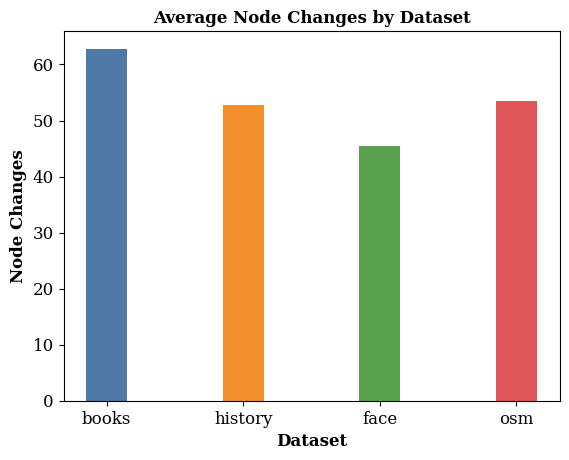

In [ ]:
colors = ['#4E79A7', '#F28E2B', '#59A14F', '#E15759']
averages = []

for i, file_name in enumerate(csv_file_names):
    idx = 0
    data = []
    df = pd.read_csv(file_name)
    
    for depth, up, down in df.itertuples(index=False):
        try:
            int(depth)
            if len(data) <= idx:
                data.append(up + down)
            else:
                data[idx] += up + down
        except ValueError:
            idx += 1
    
    avg = np.mean(data) if data else float('nan')
    averages.append(avg)

fig, ax = plt.subplots()

for i, dataset in enumerate(datasets):
    ax.bar(dataset, averages[i], 0.3, color=colors[i])

ax.set_title('Average Node Changes by Dataset', fontweight='bold', fontsize=12)
ax.set_xlabel('Dataset', fontweight='bold', fontsize=12)
ax.set_ylabel('Node Changes', fontweight='bold', fontsize=12)
ax.tick_params(axis='both', labelsize=12)
plt.show()

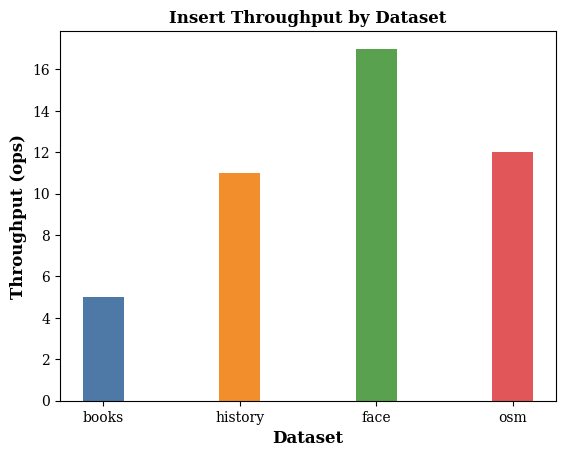

In [ ]:
colors = ['#4E79A7', '#F28E2B', '#59A14F', '#E15759']

file_name = os.path.join(build_path, 'out.csv')
df = pd.read_csv(file_name)

throughput_means = df.groupby('key_path', sort=False)['throughput'].mean()

latency_percentiles = ["50 percentile", "90 percentile", "99 percentile", "99.9 percentile", "99.99 percentile"]

latencies = df.set_index('key_path')[latency_percentiles].T

fig, ax = plt.subplots()

xticks = [index.split('/')[-1] for index in throughput_means.index]

for i, dataset in enumerate(datasets):
    ax.bar(xticks[i], throughput_means.values[i], 0.3, color=colors[i])
    
ax.set_title('Insert Throughput by Dataset', fontweight='bold', fontsize=12)
ax.set_xlabel('Dataset', fontweight='bold', fontsize=12)
ax.set_ylabel('Throughput (ops)', fontweight='bold', fontsize=12)
ax.yaxis.set_major_formatter(formatter)


In [ ]:
file_name = os.path.join(build_path, 'out.csv')
df = pd.read_csv(file_name)

latency_percentiles = ['50 percentile', '90 percentile', '99 percentile', '99.9 percentile', '99.99 percentile']
xlabels = ['50%', '90%', '99%', '99.9%', '99.99%']

datasets = df['key_path'].unique()
n_datasets = len(datasets)
n_percentiles = len(latency_percentiles)

group_width = 0.8
bar_width = group_width / n_datasets
indices = np.arange(n_percentiles)

fig, ax = plt.subplots(figsize=(10, 6))

for i, dataset in enumerate(datasets):
    latencies = df[df['key_path'] == dataset][latency_percentiles].mean()
    offsets = indices - group_width / 2 + i * bar_width + bar_width / 2
    label = dataset.split('/')[-1]
    ax.bar(offsets, latencies, bar_width, label=label)

ax.set_title('Insert Tail Latency by Dataset', fontweight='bold', fontsize=12)
ax.set_xlabel('Percentile', fontweight='bold', fontsize=12)
ax.set_ylabel('Latency (ns)', fontweight='bold', fontsize=12)
ax.set_xticks(indices)
ax.set_xticklabels(xlabels)
ax.set_yscale('log')
ax.tick_params(axis='both', labelsize=12)
ax.legend(title='Dataset')

In [ ]:
file_name = os.path.join(build_path, 'out.csv')
df = pd.read_csv(file_name)

xticks = set(df['insert_ratio'])
ymax = 1.3 * 1e7

plt.figure(figsize=(10, 6))

for key_path in df['key_path'].unique():
    subset = df[df['key_path'] == key_path]
    label = key_path.split('/')[-1]
    plt.scatter(subset['insert_ratio'], subset['throughput'], label=label)
    plt.plot(subset.sort_values('insert_ratio')['insert_ratio'], subset.sort_values('insert_ratio')['throughput'], marker='o', linestyle='-')

plt.title('Throughput per Insert Ratio', fontweight='bold')
plt.xlabel('Insert Ratio', fontweight='bold')
plt.ylabel('Throughput', fontweight='bold')
plt.xticks(list(xticks))
plt.ylim(0, ymax * 1.1)
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
plt.grid(axis='y')

ymax = 10 * 1e9

ax2 = plt.twinx()
for key_path in df['key_path'].unique():
    subset = df[df['key_path'] == key_path].sort_values('insert_ratio')
    ax2.plot(subset['insert_ratio'], subset['memory_consumption'], 'x', markersize=8, markeredgewidth=2)

ax2.set_ylabel('Index Size', fontweight='bold')
ax2.set_ylim(0, ymax * 1.1)

plt.show()